In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import seaborn as sns
from tensorflow import keras
from keras.models import Input, Model
from keras.layers import Dense, LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, auc, roc_curve
# np.random.seed(13)

In [51]:
def mar(test, pred):
    p = pred.values.astype(bool)
    t = test.values.astype(bool)
    fn = (~p & t).sum()
    tp = (p & t).sum()
    return fn / (tp + fn)

def far(test, pred):
    p=pred.values.astype(bool)
    t=test.values.astype(bool)
    fp = (p & ~t).sum()
    tn = (~p & ~t).sum()
    return fp / (fp + tn)
def f1_score(test, pred):
    p=pred.values.astype(bool)
    t=test.values.astype(bool)
    tp = (p & t).sum()
    fp = (p & ~t).sum()
    fn = (~p & t).sum()
    return tp / (tp + 0.5 * (fp + fn))

In [30]:
df = pd.read_csv('data/valve1/0.csv', 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True)

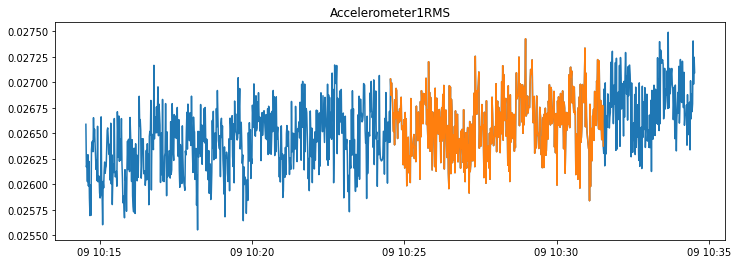

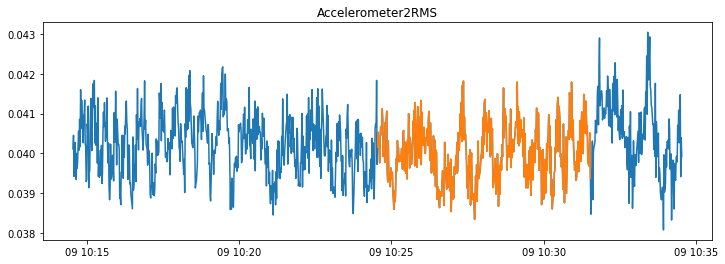

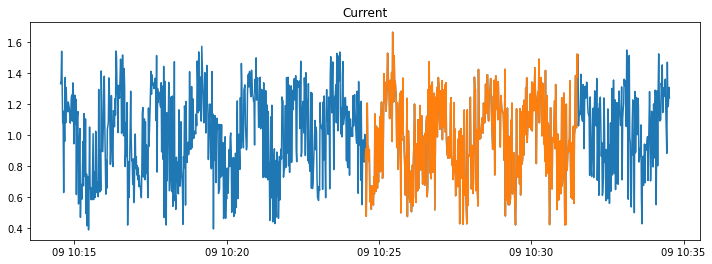

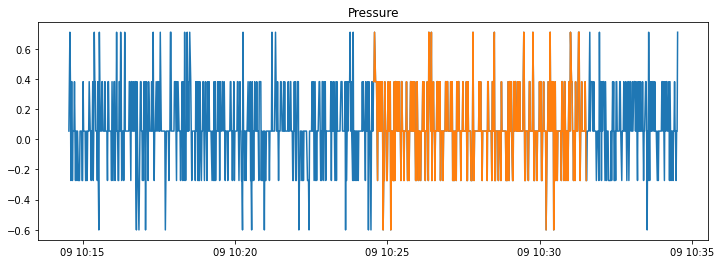

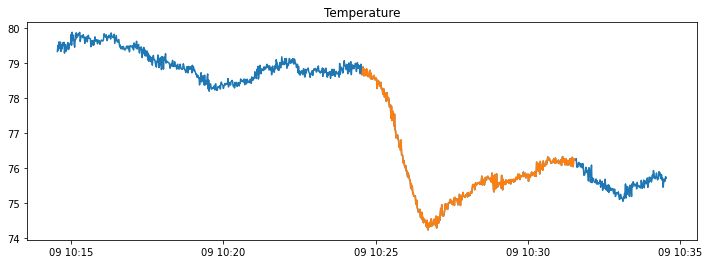

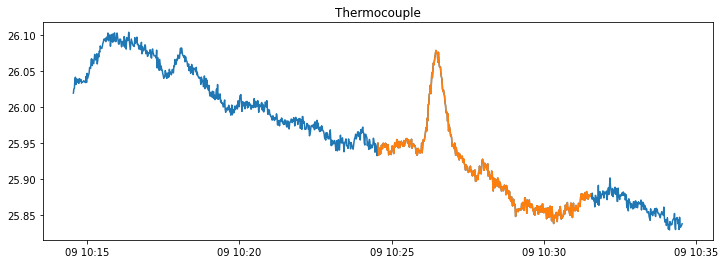

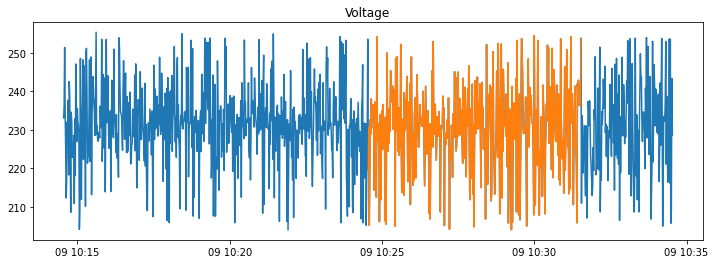

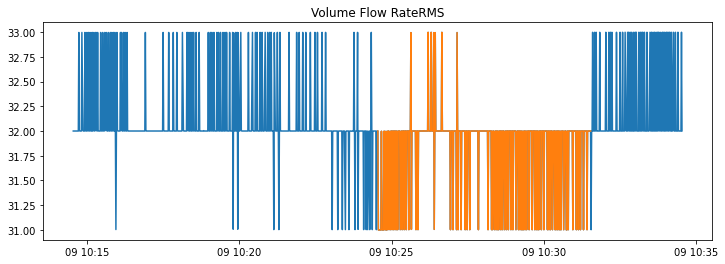

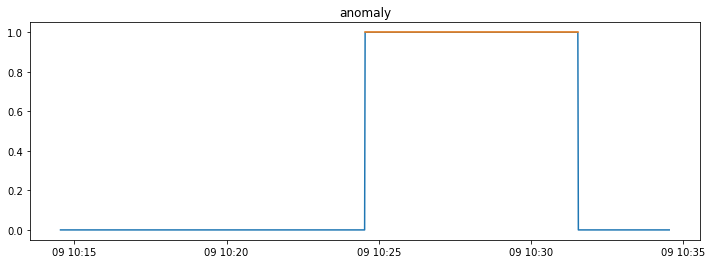

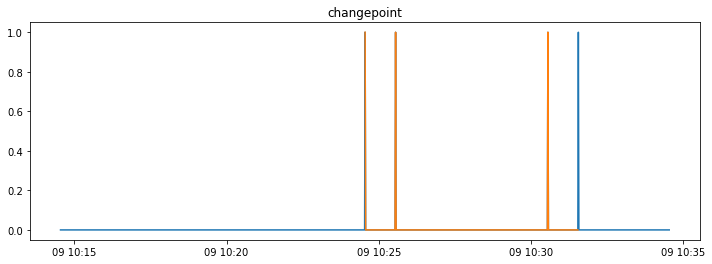

In [31]:
y = df.anomaly
anomalies_indecies = y.index[y == 1]

for c in df.columns:
    plt.figure(figsize=(12,4))
    plt.plot(df[c])
    plt.plot(anomalies_indecies, df[c][anomalies_indecies])
    plt.title(c)
    plt.show()

In [32]:
train_size = 400

In [33]:
X_train = df[:train_size].drop(['anomaly','changepoint'], axis=1)

In [34]:
N_STEPS = 10
Q = 0.99 # quantile for upper control limit (UCL) selection

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [35]:
from tensorflow.keras import layers
def arch(data):
    EPOCHS = 100
    BATCH_SIZE = 32
    VAL_SPLIT = 0.1
    
#     Random(0)    
    # model defining
    # define encoder
    inputs = keras.Input(shape=(data.shape[1], data.shape[2]))
    encoded = keras.layers.LSTM(100, activation='relu')(inputs)

    # define reconstruct decoder
    decoded = layers.RepeatVector(data.shape[1])(encoded)
    decoded = layers.LSTM(100, activation='relu', return_sequences=True)(decoded)
    decoded = layers.TimeDistributed(layers.Dense(data.shape[2]))(decoded)

    # tie it together
    model = keras.Model(inputs, decoded)
    encoder = keras.Model(inputs, encoded)

    model.compile(optimizer='adam', loss='mae', metrics=["mse"])
    
    # callbacks defining
    early_stopping = EarlyStopping(patience=5, verbose=0)
#     reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=0)
    
    # model fitting
    history = model.fit(data, data,
                        validation_split=VAL_SPLIT,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0,
                        shuffle=False,
                        callbacks=[early_stopping]#, reduce_lr]
                        )
    return history, model

In [36]:
N_STEPS = 10
Q = 0.99  # quantile for upper control limit (UCL) selection

X_train = df[:train_size].drop(['anomaly', 'changepoint'], axis=1)
StSc = StandardScaler()
StSc.fit(X_train)

X = create_sequences(StSc.transform(X_train), N_STEPS)
X.shape

(391, 10, 8)

In [37]:
history, model = arch(X)#fit 

# results predicting
predicted = model.predict(X)
residuals = pd.Series(np.sum(np.mean(np.abs(X - predicted ), axis=1), axis=1))
UCL = residuals.quantile(Q)
residuals

0      3.895572
1      3.923204
2      4.361425
3      3.939044
4      3.918762
         ...   
386    5.700958
387    5.710125
388    5.422089
389    5.339037
390    4.984892
Length: 391, dtype: float64

In [38]:
np.abs(X - predicted).shape

(391, 10, 8)

In [39]:
np.mean(np.abs(X - predicted ), axis=1).shape#окно длины 10 свернули в один вектор (длины 8). Таких 391
#каждое окно заменили его средним значением.

(391, 8)

In [40]:
np.sum(np.mean(np.abs(X - predicted ), axis=1), axis=1).shape

(391,)

In [41]:
X.shape, UCL

((391, 10, 8), 5.4858091665923325)

In [42]:
X = create_sequences(StSc.transform(df.drop(['anomaly', 'changepoint'], axis=1)), N_STEPS)
cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data = cnn_residuals > (3 / 2 * UCL)
residuals

0      3.895572
1      3.923204
2      4.361425
3      3.939044
4      3.918762
         ...   
386    5.700958
387    5.710125
388    5.422089
389    5.339037
390    4.984892
Length: 391, dtype: float64

In [43]:
anomalous_data_indices = []
for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
    if np.all(anomalous_data[data_idx - N_STEPS + 1: data_idx]):
        anomalous_data_indices.append(data_idx)

prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1

prediction.sum()

485

In [44]:
prediction

datetime
2020-03-09 10:14:33    0
2020-03-09 10:14:34    0
2020-03-09 10:14:35    0
2020-03-09 10:14:36    0
2020-03-09 10:14:37    0
                      ..
2020-03-09 10:34:28    0
2020-03-09 10:34:29    0
2020-03-09 10:34:30    0
2020-03-09 10:34:31    0
2020-03-09 10:34:32    0
Length: 1147, dtype: int64

Text(0.5, 1.0, 'Temperature')

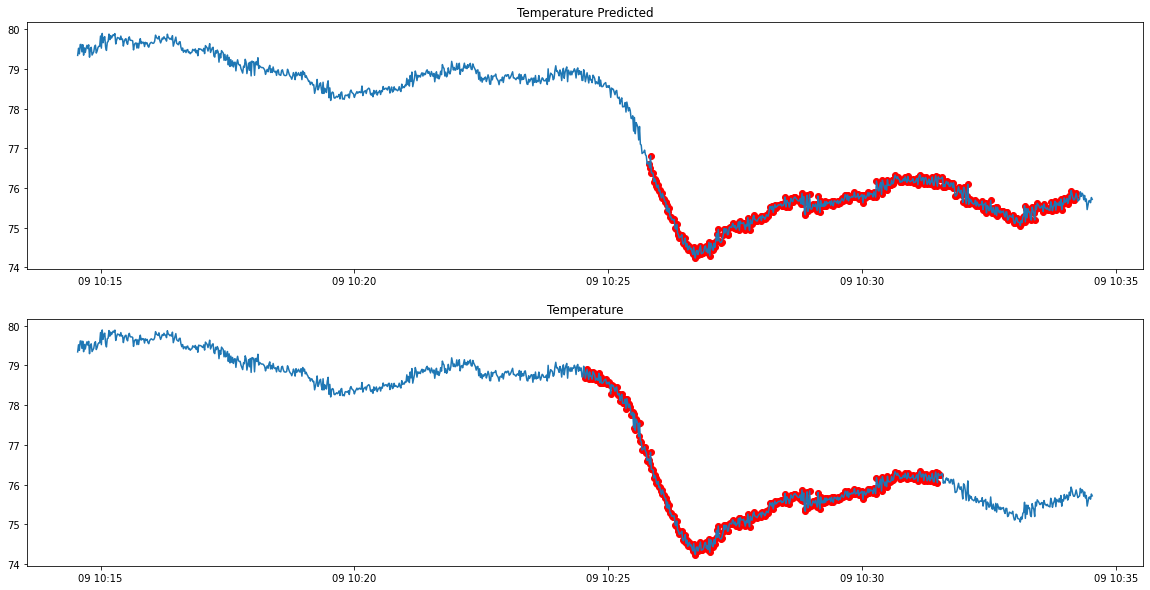

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
values = df.Temperature
axs[0].plot(values)

y = prediction
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, values[anomalies_indecies], color='r')
# #axs.scatter(cpi, temperatures[cpi], color='g', marker='^', s=300)
axs[0].set_title("Temperature Predicted")

axs[1].plot(values)
y = pd.Series(df.anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], values[anomalies_indecies], color='r')
# #axs.scatter(cpi, temperatures[cpi], color='g', marker='^', s=300)
axs[1].set_title("Temperature")

In [56]:
mar(df.anomaly, prediction), far(df.anomaly, prediction), f1_score(df.anomaly, prediction)


(0.1770573566084788, 0.20777479892761394, 0.744920993227991)